=== INFORMASI DATASET ===
Shape: (145, 15)

5 data pertama:
  Student_ID Student_Age     Sex High_School_Type Scholarship Additional_Work  \
0   STUDENT1       19-22    Male            Other         50%             Yes   
1   STUDENT2       19-22    Male            Other         50%             Yes   
2   STUDENT3       19-22    Male            State         50%              No   
3   STUDENT4          18  Female          Private         50%             Yes   
4   STUDENT5       19-22    Male          Private         50%              No   

  Sports_activity Transportation  Weekly_Study_Hours Attendance Reading Notes  \
0              No        Private                   0     Always     Yes   Yes   
1              No        Private                   0     Always     Yes    No   
2              No        Private                   2      Never      No    No   
3              No            Bus                   2     Always      No   Yes   
4              No            Bus                

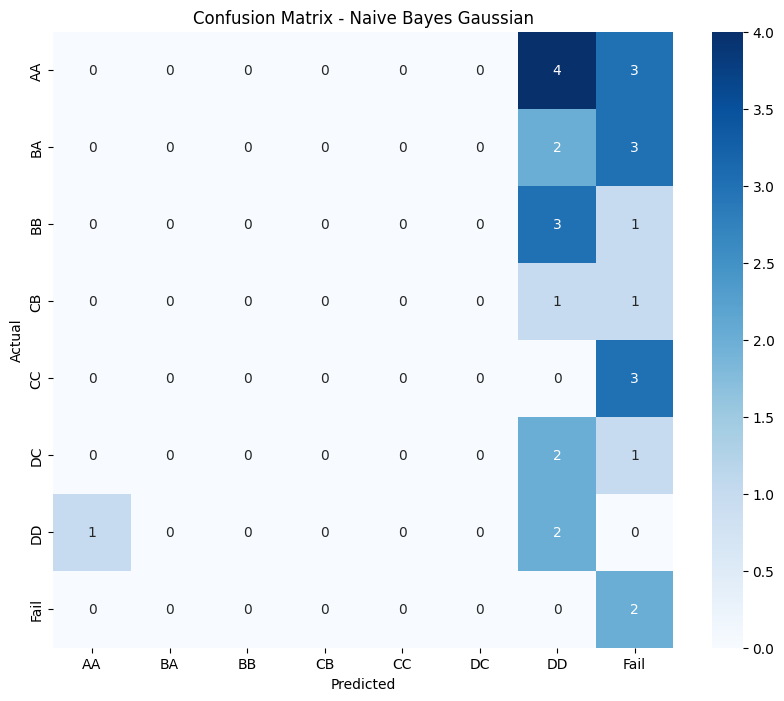

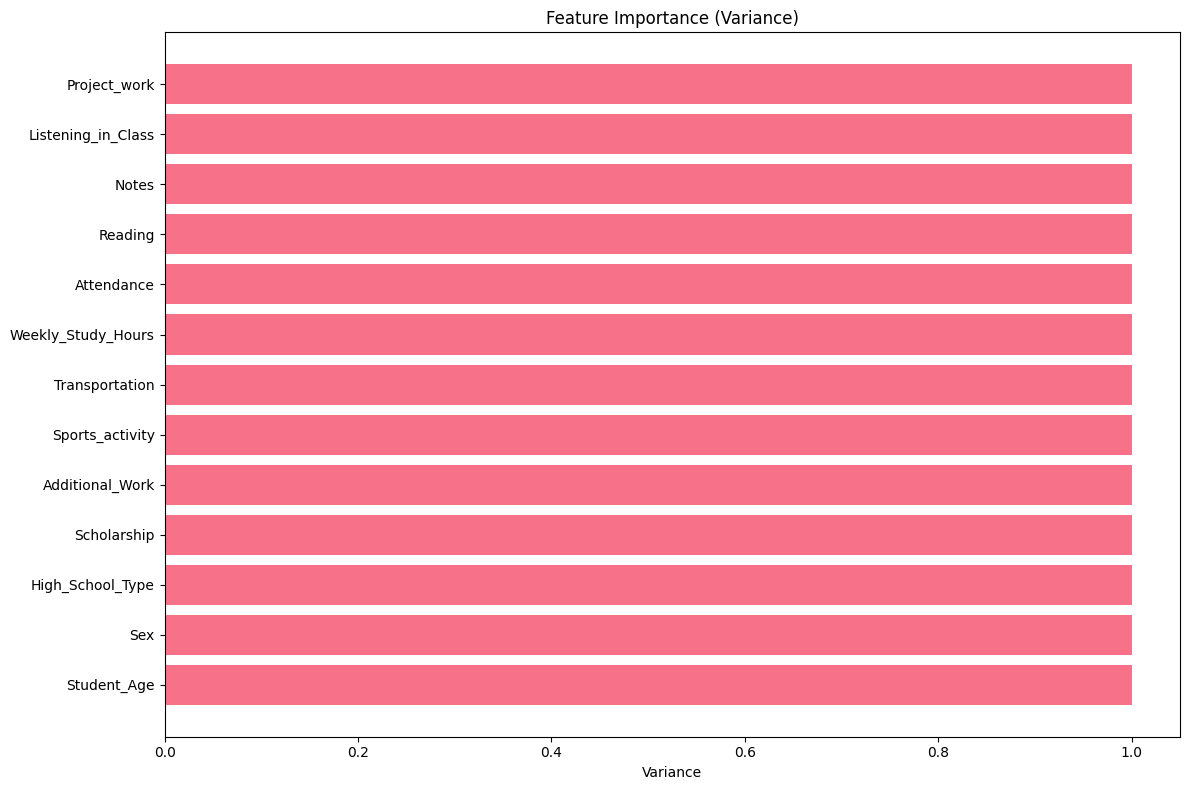


=== CONTOH HASIL PREDIKSI ===
  Actual Predicted  Confidence
0     DC        DD    0.995221
1     DC        DD    0.962521
2     BB        DD    0.999687
3     CC      Fail    0.997541
4     AA        DD    0.999082
5     CB        DD    0.998392
6     CC      Fail    0.936086
7     BB        DD    0.997609
8     AA        DD    0.998570
9     BB      Fail    0.999678


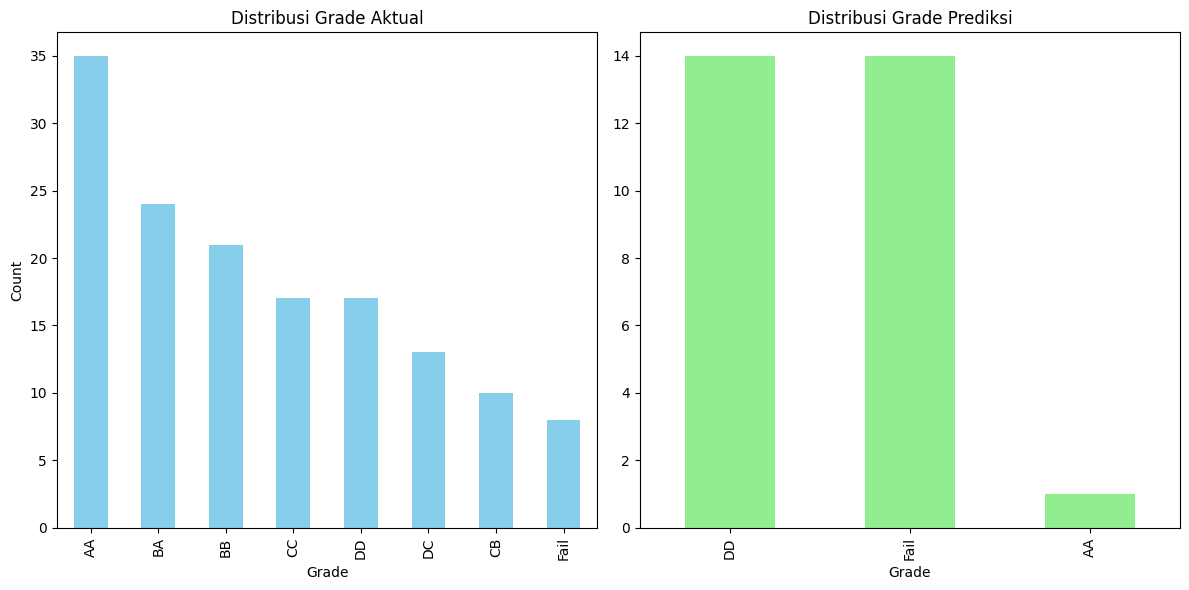


=== CROSS-VALIDATION RESULTS ===
CV Scores: [0.20833333 0.17391304 0.2173913  0.26086957 0.        ]
Mean CV Accuracy: 0.1721 (+/- 0.1808)

=== PREDIKSI DATA BARU (CONTOH) ===
Predicted Grade: DD
Prediction Probabilities:
  AA: 0.0000
  BA: 0.0001
  BB: 0.0003
  CB: 0.0000
  CC: 0.0003
  DC: 0.0002
  DD: 0.9991
  Fail: 0.0000

Model dan preprocessing objects telah disimpan!


In [6]:
# -*- coding: utf-8 -*-
"""
Naive Bayes Gaussian untuk Prediksi Performa Siswa
"""

# Import library yang diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer

# Load dataset
df = pd.read_csv(r"C:\Users\hp 745\Downloads\Students Performance .csv")


# Eksplorasi data awal
print("=== INFORMASI DATASET ===")
print(f"Shape: {df.shape}")
print("\n5 data pertama:")
print(df.head())
print("\nInfo dataset:")
print(df.info())
print("\nStatistik deskriptif:")
print(df.describe())
print("\nMissing values:")
print(df.isnull().sum())

# Preprocessing data
print("\n=== PREPROCESSING DATA ===")

# Handle missing values - ganti '6' dengan NaN lalu impute
df = df.replace('6', np.nan)

# Impute missing values untuk kolom kategorikal
categorical_cols = ['Student_Age', 'Sex', 'High_School_Type', 'Scholarship', 'Additional_Work', 
                   'Sports_activity', 'Transportation', 'Attendance', 'Reading', 'Notes', 
                   'Listening_in_Class', 'Project_work']

for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        mode_val = df[col].mode()[0]
        df[col].fillna(mode_val, inplace=True)

# Impute missing values untuk kolom numerik
if df['Weekly_Study_Hours'].isnull().sum() > 0:
    df['Weekly_Study_Hours'].fillna(df['Weekly_Study_Hours'].median(), inplace=True)

# Konversi Scholarship ke numeric
df['Scholarship'] = df['Scholarship'].replace({'None': '0%', '100%': '100', '75%': '75', '50%': '50', '25%': '25'})
df['Scholarship'] = df['Scholarship'].str.rstrip('%').astype(float) / 100

# Encode variabel kategorikal
label_encoders = {}
categorical_features = ['Student_Age', 'Sex', 'High_School_Type', 'Additional_Work', 
                       'Sports_activity', 'Transportation', 'Attendance', 'Reading', 
                       'Notes', 'Listening_in_Class', 'Project_work']

for feature in categorical_features:
    le = LabelEncoder()
    df[feature] = le.fit_transform(df[feature].astype(str))
    label_encoders[feature] = le

# Pisahkan features dan target
X = df.drop(['Student_ID', 'Grade'], axis=1)
y = df['Grade']

# Encode target variable
le_grade = LabelEncoder()
y_encoded = le_grade.fit_transform(y)

# Split data menjadi training dan testing set
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Gaussian Naive Bayes model
print("\n=== TRAINING MODEL NAIVE BAYES GAUSSIAN ===")
gnb = GaussianNB()
gnb.fit(X_train_scaled, y_train)

# Predictions
y_pred = gnb.predict(X_test_scaled)
y_pred_proba = gnb.predict_proba(X_test_scaled)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
print(f"Akurasi Model: {accuracy:.4f}")

print("\n=== LAPORAN KLASIFIKASI ===")
print(classification_report(y_test, y_pred, target_names=le_grade.classes_))

# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le_grade.classes_, 
            yticklabels=le_grade.classes_)
plt.title('Confusion Matrix - Naive Bayes Gaussian')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Feature importance (berdasarkan variance)
feature_importance = np.var(X_train_scaled, axis=0)
feature_names = X.columns

plt.figure(figsize=(12, 8))
plt.barh(feature_names, feature_importance)
plt.title('Feature Importance (Variance)')
plt.xlabel('Variance')
plt.tight_layout()
plt.show()

# Analisis hasil prediksi
results_df = pd.DataFrame({
    'Actual': le_grade.inverse_transform(y_test),
    'Predicted': le_grade.inverse_transform(y_pred),
    'Confidence': np.max(y_pred_proba, axis=1)
})

print("\n=== CONTOH HASIL PREDIKSI ===")
print(results_df.head(10))

# Distribusi grade
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
df['Grade'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribusi Grade Aktual')
plt.xlabel('Grade')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
pd.Series(le_grade.inverse_transform(y_pred)).value_counts().plot(kind='bar', color='lightgreen')
plt.title('Distribusi Grade Prediksi')
plt.xlabel('Grade')
plt.tight_layout()
plt.show()

# Cross-validation untuk evaluasi lebih robust
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(gnb, X_train_scaled, y_train, cv=5, scoring='accuracy')
print(f"\n=== CROSS-VALIDATION RESULTS ===")
print(f"CV Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Prediksi untuk data baru (contoh)
print("\n=== PREDIKSI DATA BARU (CONTOH) ===")
sample_data = X_train_scaled[:1]  # Ambil sample dari training data
sample_pred = gnb.predict(sample_data)
sample_pred_proba = gnb.predict_proba(sample_data)

print(f"Predicted Grade: {le_grade.inverse_transform(sample_pred)[0]}")
print("Prediction Probabilities:")
for grade, proba in zip(le_grade.classes_, sample_pred_proba[0]):
    print(f"  {grade}: {proba:.4f}")

# Simpan model dan preprocessing objects (opsional)
import joblib

joblib.dump(gnb, 'naive_bayes_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(le_grade, 'label_encoder_grade.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')

print("\nModel dan preprocessing objects telah disimpan!")